In [1]:
# !pip install langchain-core --upgrade
# !pip install Pydantic --upgrade 
# !pip install -qU duckduckgo-search langchain-community

In [2]:
import langchain
from langchain_google_genai import ChatGoogleGenerativeAI 

c:\Users\Vinitha\anaconda3\envs\langchain_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [4]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("langchain_api_key")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [5]:
# Load the LLM model for the generation
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [6]:
# Prepare the embedding model for the vector similarity search
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore
vector_store_1 = InMemoryVectorStore(embeddings)

In [8]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
bs4_strainer = bs4.SoupStrainer(class_=("post"))

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [9]:
loader = WebBaseLoader(web_path="https://jalammar.github.io/illustrated-transformer/",
                        bs_kwargs={"parse_only": bs4_strainer}
                        )
docs = loader.load()

In [10]:
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

Total characters: 24876

The Illustrated Transformer

Discussions:
Hacker News (65 points, 4 comments), Reddit r/MachineLearning (29 points, 3 comments)


Translations: Arabic, Chinese (Simplified) 1, Chinese (Simplified) 2, French 1, French 2, Italian, Japanese, Korean, Persian, Russian, Spanish 1, Spanish 2, Vietnamese

Watch: MIT’s Deep Learning State of the Art lecture referencing this post

Featured in courses at Stanford, Harvard, MIT, Princeton, CMU and others





Update: This post has now become a book! Check 


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
split_chunks = text_splitter.split_documents(docs)

print(f"Split blog post into {len(split_chunks)} sub-documents.")

Split blog post into 37 sub-documents.


In [12]:
document_ids = vector_store_1.add_documents(documents=split_chunks)
retriever = vector_store_1.as_retriever()

In [13]:
from langchain.tools.retriever import create_retriever_tool
from langchain_community.tools import DuckDuckGoSearchResults

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_context_on_attention",
    "Search and return information about Transformers and the attention mechanism used in the Language processing tasks",
)


search_tool = DuckDuckGoSearchResults()

tools = [retriever_tool,search_tool]

In [15]:
search_tool.invoke({'query': 'Which is the captial of China?'})

'snippet: Beijing, city, province-level shi (municipality), and capital of the People\'s Republic of China. The city has been an integral part of China\'s history over the past eight centuries. Redolent with historical, cultural, and political significance, it is one of the world\'s great cities. Learn more about Beijing here., title: Beijing | Province, City, History, Map, & Facts | Britannica, link: https://www.britannica.com/place/Beijing, snippet: Capital of China. Written by Matteo Updated May. 30, 2024. Beijing, which means "Northern Capital" (from the Chinese characters 北 for north and 京 for capital), is the capital of the People\'s Republic of China and one of the most heavily populated cities in the world., title: What Is the Capital of China? Beijing - National Capital - China Travel, link: https://www.chinatravel.com/guide/capital-of-china, snippet: Beijing, Jing for short, is a metropolis in northern China and the capital of China. Lying 70 mi (102 km) west of Bohai Sea, it

In [16]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages,BaseMessage
from typing import Annotated, Sequence

class State(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [17]:
from langchain_core.prompts import PromptTemplate

rag_prompt = PromptTemplate.from_template("""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context}
Answer:
""")

In [18]:
def generate(state:State):
    print("GENERATING USING THE RETRIEVED CONTENT")
    question = state["messages"][0].content
    retrieved_contents = state["messages"][-1].content
    rag_message = rag_prompt.invoke({"question":question,"context":retrieved_contents})
    llm_response = llm.invoke(rag_message).content
    return {"messages":[llm_response]}

In [19]:
def web_search(state:State):
    print("Initiating the web search")
    question = state["messages"][0].content
    search_result = search_tool.invoke({"query": question})
    print(search_result)
    return {"messages":[search_result]}

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm2 = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [21]:
def agent(state):  
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm2.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [22]:
def custom_tool_condition(state):
    messages = state["messages"][-1]
    tool_name = messages.additional_kwargs["function_call"]["name"]
    
    if tool_name == "retrieve_context_on_attention":
        return "retrieve_tool"
    else:
        return "search_tool"

In [23]:
# Graph structure to see the control flow
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [24]:

workflow = StateGraph(State)

workflow.add_node("agent", agent) 

retrieve_tool_node = ToolNode([retriever_tool]) 
search_tool_node = ToolNode([search_tool])

workflow.add_node("retrieve_tool", retrieve_tool_node) 
workflow.add_node("search_tool", search_tool_node) 
workflow.add_node("generate", generate)
workflow.add_node("websearch",web_search)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    custom_tool_condition,
    {
        "retrieve_tool": "retrieve_tool",
        "search_tool": "search_tool"
    },
)

workflow.add_edge("retrieve_tool", "generate")
workflow.add_edge("search_tool", "websearch")
workflow.add_edge("websearch",END)
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()

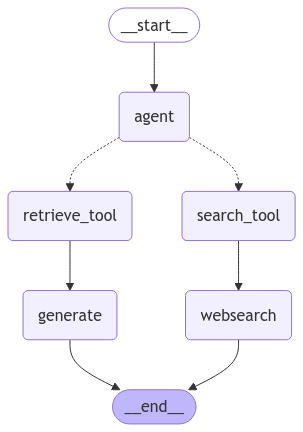

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
result = graph.invoke({"messages":[("user","What is attention mechanism?")]}) 
print(result["messages"][-1].content)

---CALL AGENT---
GENERATING USING THE RETRIEVED CONTENT
An attention mechanism allows a model to focus on different parts of an input sequence when processing each word.  In the example, when processing "it," the attention mechanism helps the model associate "it" with "animal" and "tired" by incorporating their representations into the encoding of "it".  This allows the model to better understand the context and meaning of the word.



In [28]:
# result = graph.invoke({"messages":[("user","What is the fastest animal in the world?")]}) 
print(result["messages"][-1].content)

snippet: Learn about the fastest animal in the world, the peregrine falcon, and its diving speed of 242 miles per hour. Also discover the fastest mammal, the Mexican free-tailed bat, and the fastest insect, the male horsefly, and their amazing adaptations., title: The Fastest Animals On Planet Earth (242 MPH!?), link: https://a-z-animals.com/animals/lists/fastest-animals/, snippet: The **Peregrine Falcon** swoops down at an incredible 389 km/h, making it the fastest in the world. Then there's the **Pronghorn**, racing at 88.5 km/h. This list will take you on a journey through the animal kingdom and showcase the incredible speed and agility of some of nature's most impressive creatures., title: 25 Fastest Animals Ranked by Speed - List25, link: https://list25.com/25-fastest-animals-ranked-by-speed/, snippet: The Pronghorn, native to North America, is the fastest land animal in the Western Hemisphere. It can run at speeds of up to 55 miles per hour (88 kilometers per hour). Unlike the Ch